In [118]:
import pandas as pd
import numpy as np 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
import re
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
import matplotlib.patches as mpatches
import seaborn as sns
from textblob import TextBlob

In [119]:
food = pd.read_csv('./fastfood.csv', index_col=0)

In [120]:
food.shape

(48294, 14)

In [121]:
food = food.drop_duplicates()

In [122]:
food.shape

(44998, 14)

In [123]:
food.reset_index(inplace=True, drop=True)

In [131]:
food = food.drop(food[food.isnull().all(axis=1)].index[0], axis=0).reset_index(drop=True)

In [143]:
to_drop = []

for row_num, val in enumerate(food['Company']):
    if val[0] != '@':
        to_drop.append(row_num)
        
food = food.drop(to_drop, axis=0).reset_index(drop=True)

In [154]:
food['user_is_verified'] = food['user_is_verified'].fillna(0).astype(int)

In [164]:
#Set to run Midnight and 5pm EST everyday, the times are in UTC
food['time_tweeted'] = pd.to_datetime(food['time_tweeted']) - pd.Timedelta(hours=4)

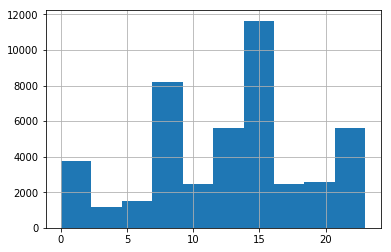

In [166]:
food['time_tweeted'].dt.hour.hist()

In [178]:
#shouldnt be removing stopwords before sentiment analysis:
#http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf

def Text_Cleaner(text):
    """Takes text, eliminates URLS, tokenizes, removes company names, lower cases, removes calls to twitter handles, 
    returns a string"""
    
    text = re.sub(r'(https)[^\s]+', '', text)
    text = re.sub(r'\b(rt|RT)', '', text)
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    words = [word for word in words if word != 'rt']
    lower = [x.lower() for x in words]
    eliminator = [re.sub(r'(mcdon|dunki|denn|redro|sonic|starb|shakesh|domino|crackerb|chipot|wend)[a-z]+','',x)
                  for x in lower]
    eliminator2 = [re.sub(r'@[a-zA-Z0-9]+', '', x) for x in eliminator]
    return ' '.join(eliminator2)

In [180]:
food['text_sentiment'] = food['text'].apply(Text_Cleaner)

In [181]:
food['sentiment_score'] = food['text_sentiment'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [184]:
#companies ordered by mean sentiment (0 neutral, 1 positive, -1 negative)
food.groupby('Company')['sentiment_score'].mean().sort_values()

Company
@dominos            0.061531
@dunkindonuts       0.085273
@wingstop           0.094806
@sonicdrivein       0.112251
@DennysDiner        0.121524
@ChipotleTweets     0.130115
@McDonalds          0.130750
@redrobinburgers    0.136322
@Wendys             0.143343
@Potbelly           0.167776
@CrackerBarrel      0.187128
@Starbucks          0.192941
@shakeshack         0.201470
Name: sentiment_score, dtype: float64

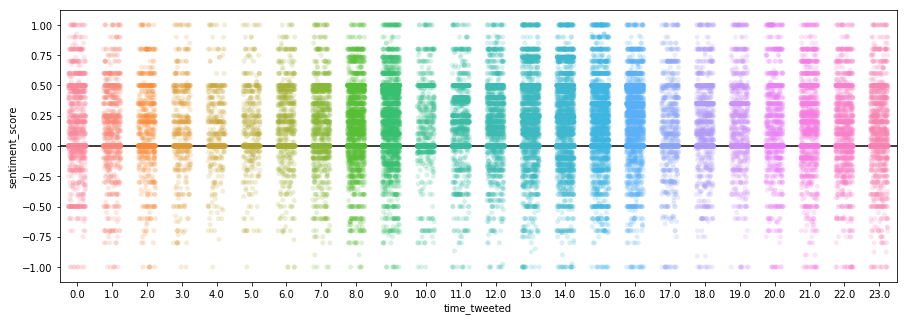

In [199]:
fig, ax = plt.subplots(figsize=(15,5))
sns.stripplot(food['time_tweeted'].dt.hour, food['sentiment_score'], jitter=.25, 
              dodge=True,alpha=0.2)
plt.axhline(y=0, c='black')